In [1]:
# Reinforcment Learning with Foirier/Polynomial State Weighted Q Basis for Homogeus Multi Component Maitenance
# By Joseph Wittrock

# Enviroment/Training code adapted from:
# https://pytorch.org/rl/stable/tutorials/torchrl_envs.html
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

# The enviroment is composed of n components with m condition states. Each component degrades each step according to its degredation transition matrix. 
# The actions to the enviroment are 0 for do nothing, or 1 for repair.
# Only k components can be repaired at a time, and the repair cost is proportional to the number of components repaired.
# If a component is in a failed state, it will have a failure cost no matter what action is taken. (Though I want to change how this works for multiperiod adaptation)
# The goal is to maximize the reward over a fixed number of steps, reward is negative for repair costs and failure costs.

# The enviroment is written using TorchRL and TensorDict for efficient paralell computation on a cuda enabled GPU.

# The state space is reduced by considering the distrobution of the components in each condition state, rather than the condition state of each component.
# This condenses the state space to m states.

# To generalize the action space we search for an "equitable" policy. i.e. a component in worse condition is always repaired before a component in better condition.
# This reduces the action space to k actions.

# For large values of m, a traditional deep Q network would not generalize well, as there are too many output neurons.
# Instead, we use a basis of continuous valued functions over [0,1], and map the action space to i \mapsto i/k for i in [0,k]. 
# Note when i=0, no components are repaired, and when i=k, all components are repaired, so there are k+1 actions in total.

# The degrees of approximation determine the output nodes for the neural network, then the output is dot producted with the basis functions evaluated at the precalculated action domain points.
# This allows for scale free computation for increasing values of the repair constraint.

In [2]:
from typing import Optional

from matplotlib import pyplot as plt # for plotting
import numpy as np # for cpu based computation
import torch # for efficient (gpu) computation and automatic differentiation
from tqdm import tqdm # for progress bars
from tensordict import TensorDict, TensorDictBase # for handling dictionaries of tensors in a pytorch friendly way, e.g. for batched data
from torch import nn # for neural networks
import torch.optim as optim # for optimizers
import torch.nn.functional as F # for activation functions
from torch.utils.tensorboard import SummaryWriter # for logging to tensorboard


# TorchRL
from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec # for defining the shape and type of data [Legacy]
from torchrl.data import Bounded, Composite, Unbounded # for defining the shape and type of data
from torchrl.envs import (
    CatTensors, # Concatenate tensors
    EnvBase, # Tensordict based env
    Transform, # Transform for envs
)
from torchrl.envs.transforms.transforms import _apply_to_composite # for applying a transform to a composite spec
from torchrl.envs.utils import check_env_specs, step_mdp # for checking env specs and stepping through an MDP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # enable cuda if available 
print(f"Using device: {device}")
torch.set_default_device(device)

Using device: cuda


In [3]:
######################
#                    #
#   HYPERPARAMETERS  #
#                    #
######################

# Environment parameters
N_COMPONENTS = 1000 # number of components in each enviroment
MAX_REPAIR_CONSTRAINT = 750 # Maximum number of components that can be repaired in a single step
EPISODE_LENGTH = 128 # number of steps in each episode
STEP_BATCH_SIZE = 128 # number of environments to be executed in paralell
# - Cost parameters
# REPAIR_COST = 10.0 # cost per repair action taken each step
# FAILURE_COST = 20.0 # cost per maximum state (failed state) component each step
REWARD_BLEND = 0.65 # weight for blending orm costs and utility

# Optimization parameters
OPTIMIZATION_BATCH_SIZE = 64 * EPISODE_LENGTH # number of transitions to be used used in each optimization batch
BUFFER_SIZE = 1 * STEP_BATCH_SIZE * EPISODE_LENGTH # number of transitions to be stored in the memory replay buffer
OPTIMIZATION_PASSES = 1 # number of optimization passes to be made in each step
GAMMA = 1 # reward discount factor \in [0, 1]
TAU = 1e-2 # soft target network learning rate. \in [0, 1]
LR = 1e-3 # learning rate for policy network. \in [0, 1]
N_EPISODES = 128
EPOCHS = N_EPISODES * EPISODE_LENGTH  # number of epochs to train the policy network
# - Entropy parameters
ENTROPY_START = 0.75 # initial entropy value for random actions
ENTROPY_END = 0.15  # entropy value for random actions
ENTROPY_DECAY = 5_000  # entropy decay rate 
# - Agent Network parameters
BASIS =   "polynomial" # "fourier" #
N_DEEP_NODES = 32 # number of nodes in the deep network
DEGREE_APPROXIMATION = 3 # basis elements to be generated for action value approximation



In [4]:
###### Generate Other Parameters ######

# evaluate basis functions at every relevant action
# a = k / MAX_REPAIR_CONSTRAINT \in [0, 1] 
# for k \in { 0, 1, 2, ...,  MAX_REPAIR_CONSTRAINT }
basis_switch = { 
    "polynomial": torch.tensor([
        [ (n / MAX_REPAIR_CONSTRAINT )**k for n in range(MAX_REPAIR_CONSTRAINT ) ] 
        for k in range(DEGREE_APPROXIMATION)
    ], dtype=torch.float32),
    "fourier": torch.tensor([
        [np.cos(1 * np.pi * k * n / MAX_REPAIR_CONSTRAINT) for n in range(MAX_REPAIR_CONSTRAINT )]
        for k in range(DEGREE_APPROXIMATION)
    ], dtype=torch.float32),
    }
basis = basis_switch[ BASIS ]


def get_basis(degree: int, max_repair_constraint: int, basis_type: str = "polynomial") -> torch.Tensor:
    if basis_type == "polynomial":
        return torch.tensor([
            [ (n / max_repair_constraint )**k for n in range(max_repair_constraint ) ] 
            for k in range(degree)
        ], dtype=torch.float32)
    elif basis_type == "fourier":
        return torch.tensor([
            [np.cos(1 * np.pi * k * n / max_repair_constraint) for n in range(max_repair_constraint )]
            for k in range(degree)
        ], dtype=torch.float32)

basis = basis.to(device)
basis.shape

# Degredation Transition Matrix
# Degredation Transition Matrix
transition_matrix_degrade = torch.tensor([
    [0.90, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.05, 0.90, 0.0, 0.0, 0.0, 0.0],
    [0.04, 0.04, 0.8, 0.0, 0.0, 0.0],
    [0.02, 0.03, 0.15, 0.8, 0.0, 0.0],
    [0.0, 0.025, 0.04, 0.1, 0.8, 0.0],
    [0.0, 0.005, 0.01, 0.1, 0.2, 1.0],
], device=device).T 

# Number of discrete condition states per component
N_CONDITION_STATES = transition_matrix_degrade.shape[0]

# Repair Matrix
transition_matrix_repair = torch.zeros((N_CONDITION_STATES, N_CONDITION_STATES), device=device)
transition_matrix_repair[:, 0] = 1.0 # send to the first state

# Pack matrices into a single tensor
transition_matrices = torch.stack([transition_matrix_degrade, transition_matrix_repair])

# Reward function
def make_r_s_a(repair_cost, failure_cost):
    r_s_a = torch.zeros(N_CONDITION_STATES, 2, device=device)
    r_s_a[:, 1] = -repair_cost
    r_s_a[-1, :] = -failure_cost
    return r_s_a

# r_s_a = make_r_s_a(REPAIR_COST, FAILURE_COST)


# Homogeneous Setup
transition_tensor = torch.cat([transition_matrices for _ in range(N_COMPONENTS)]).reshape(N_COMPONENTS, 2, N_CONDITION_STATES, N_CONDITION_STATES)
# rsa_tensor = torch.cat([r_s_a for _ in range(N_COMPONENTS)]).reshape(N_COMPONENTS, N_CONDITION_STATES, 2)

# Max cost used for normalizing rewards
# max_cost = FAILURE_COST * N_COMPONENTS

# rsa_tensor /= max_cost

In [5]:
# hyperparameter dictionary for accessing hyperparameters in other scripts

hyperparameters = TensorDict(
    N_COMPONENTS=N_COMPONENTS,
    N_CONDITION_STATES=N_CONDITION_STATES,
    MAX_REPAIR_CONSTRAINT=MAX_REPAIR_CONSTRAINT,
    EPISODE_LENGTH=EPISODE_LENGTH,
    STEP_BATCH_SIZE=STEP_BATCH_SIZE,
    # REPAIR_COST=REPAIR_COST,
    # FAILURE_COST=FAILURE_COST,
    REWARD_BLEND=REWARD_BLEND,
    OPTIMIZATION_BATCH_SIZE=OPTIMIZATION_BATCH_SIZE,
    BUFFER_SIZE=BUFFER_SIZE,
    OPTIMIZATION_PASSES=OPTIMIZATION_PASSES,
    GAMMA=GAMMA,
    TAU=TAU,
    LR=LR,
    N_EPISODES=N_EPISODES,
    EPOCHS=EPOCHS,
    ENTROPY_START=ENTROPY_START,
    ENTROPY_END=ENTROPY_END,
    ENTROPY_DECAY=ENTROPY_DECAY,
    BASIS=BASIS,
    BASIS_DOMAIN=basis,
    N_DEEP_NODES=N_DEEP_NODES,
    DEGREE_APPROXIMATION=DEGREE_APPROXIMATION,
)

hyperparameters.to(device)

# hyperparameters

TensorDict(
    fields={
        BASIS: NonTensorData(data=polynomial, batch_size=torch.Size([]), device=cuda:0),
        BASIS_DOMAIN: Tensor(shape=torch.Size([3, 750]), device=cuda:0, dtype=torch.float32, is_shared=True),
        BUFFER_SIZE: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        DEGREE_APPROXIMATION: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        ENTROPY_DECAY: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        ENTROPY_END: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        ENTROPY_START: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        EPISODE_LENGTH: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        EPOCHS: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        GAMMA: Tensor(shape=torch.Size([]), device=cud

In [6]:
# Best Hyperparameters found in the grid search

# Linear Hyperparameters:
linear_best_lr =  0.013366665691137314
# Linear AK Hyperparameters:
linear_AK_best_lr =  0.006733333226293325
linear_AK_best_degree =  3
# Linear AK Fourier Hyperparameters:
linear_AK_fourier_best_lr =  0.019170833751559258
linear_AK_fourier_best_degree =  8
# DQ Hyperparameters:
DQ_best_lr =  0.011708333157002926
DQ_best_deep =  24
# DQAK Hyperparameters:
DQAK_best_lr =  0.007562499959021807
DQAK_best_degree =  3
DQAK_best_deep =  48
# DQAK Forier Hyperparameters:
DQAK_forier_best_lr =  0.00507500022649765
DQAK_forier_best_degree =  5
DQAK_forier_best_deep =  128

test_observation = torch.tensor([0.3380, 0.3430, 0.0930, 0.1470, 0.0600, 0.0190, 0.25], device=device)

In [7]:
from maitenance_util_cost_env import DiscreteMaitenanceEnv, gen_params,  load_dynamics, generate_maitenance_env, reset_maitenance_env
from deep_q_target_training import MaitenanceDQBNTrainer

# generate utility and orm costs
utility = torch.linspace(0, 1, N_COMPONENTS, device=device) 
orm_costs = torch.linspace(0, 1, MAX_REPAIR_CONSTRAINT+1, device=device) 
orm_costs[1:] = (orm_costs[1:] + 0.3) / 1.3 # average the costs for each action

# load data into enviroment global variables

load_dynamics(transition_tensor, orm_costs, utility, hyperparameters)

# generate enviroment based on hyperparameters and transition/reward tensors
env = generate_maitenance_env(device=device)


Using device: cuda
Using device: cuda


/home/nemo/anaconda3/envs/torch/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Text(0, 0.5, 'cost')

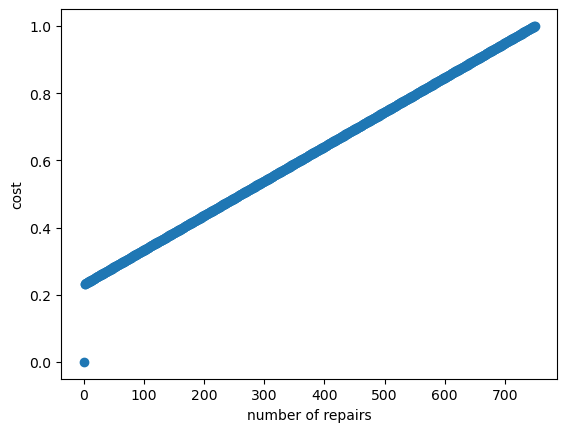

In [8]:
plt.scatter(np.arange(0, MAX_REPAIR_CONSTRAINT+1), orm_costs.cpu().numpy(), label="Utility")
plt.xlabel("number of repairs")
plt.ylabel("cost")

In [9]:
params_td = gen_params(
	batch_size=STEP_BATCH_SIZE,
	device=device,
)

td = env.reset(params_td)
td

/home/nemo/anaconda3/envs/torch/lib/python3.12/site-packages/torchrl/data/tensor_specs.py:5464: DeprecationWarning: The BoundedTensorSpec has been deprecated and will be removed in v0.7. Please use Bounded instead.
  warnings.warn(


TensorDict(
    fields={
        conditions: Tensor(shape=torch.Size([128, 1000]), device=cuda:0, dtype=torch.int64, is_shared=True),
        done: Tensor(shape=torch.Size([128, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        observation: Tensor(shape=torch.Size([128, 7]), device=cuda:0, dtype=torch.float32, is_shared=True),
        orm_costs: Tensor(shape=torch.Size([128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        params: TensorDict(
            fields={
                repair_costs: Tensor(shape=torch.Size([128, 751]), device=cuda:0, dtype=torch.float32, is_shared=True),
                transitions: Tensor(shape=torch.Size([128, 1000, 2, 6, 6]), device=cuda:0, dtype=torch.float32, is_shared=True),
                utility: Tensor(shape=torch.Size([128, 1000]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([128]),
            device=cuda:0,
            is_shared=True),
        step: Tensor(shape=torch.Size([12

In [10]:
n_repair = 0.6 * MAX_REPAIR_CONSTRAINT

def worstfirst_triage(td, n_repair):
	actions = torch.zeros(STEP_BATCH_SIZE, hyperparameters["N_COMPONENTS"], dtype=torch.int64)

	conditions = td["conditions"]

	# sort components with the highest condition
	components_by_condition = torch.argsort(conditions, dim=1, descending=True)

	# Create a mask for the top-k indices
	topk_mask = torch.arange(hyperparameters["N_COMPONENTS"], device=device).expand(STEP_BATCH_SIZE, hyperparameters["N_COMPONENTS"]) < n_repair.unsqueeze(1)

	# indicies of batches of components
	batch_indicies = torch.arange(STEP_BATCH_SIZE, device=device).unsqueeze(1).expand(STEP_BATCH_SIZE, hyperparameters["N_COMPONENTS"])[ topk_mask ]

	# indicies of components to be repaired
	topk_indices = components_by_condition[ topk_mask ]

	# set the actions of the components to be repaired
	actions[batch_indicies, topk_indices] = 1
	return actions

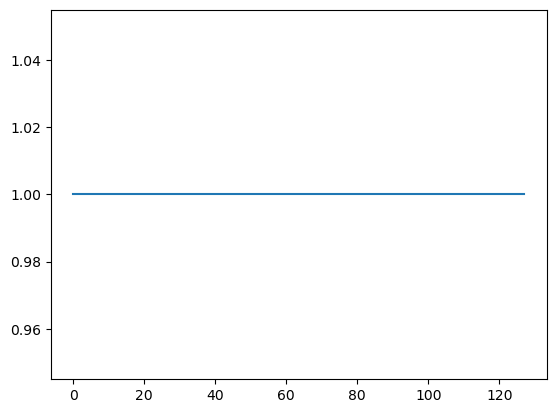

In [11]:
cache_failures = []

td = env.reset(params_td)

for i in range(EPISODE_LENGTH):
	# take action
	actions = worstfirst_triage(td, torch.tensor([n_repair]))
	td["action"] = actions
	# step the enviroment
	td = env.step(td)
	td = td["next"]
	# cache the failures
	cache_failures.append(td["utility"].cpu().numpy().mean())
	

plt.plot(cache_failures)




In [12]:
# cache_cache = []

# pbar = tqdm(total=MAX_REPAIR_CONSTRAINT, desc="Repairing Components", unit="episodes")
# step = 5
# for n_repair in range(1, MAX_REPAIR_CONSTRAINT + 1,step):
# 	td = env.reset(params_td)
# 	cache_failures = []
# 	for i in range(EPISODE_LENGTH):
# 		# take action
# 		actions = worstfirst_triage(td, n_repair)
# 		td["action"] = actions
# 		# step the enviroment
# 		td = env.step(td)
# 		# cache the failures
# 		cache_failures.append(td["observation"][:, -1].mean().item())
# 		td = td["next"]
# 	cache_cache.append(cache_failures)
# 	pbar.update(step)

# plt.figure(figsize=(10, 5))
# colors = plt.cm.viridis(np.linspace(0, 1, len(cache_cache)))
# for i, cache_failures in enumerate(cache_cache):
# 	plt.plot(cache_failures, label=f"Repair {i+1} Components", color=colors[i])
# plt.title("Worst First Triage")
# plt.xlabel("Step")
# plt.ylabel("Failures")
# plt.legend()

In [13]:
# condition thresholds

cache_cache = []

threshold_2_max = 750
threshold_2_skip = 25

pbar = tqdm(total=((N_CONDITION_STATES-1) * (threshold_2_max - 1) )// threshold_2_skip, desc="Repairing Components", unit="episodes")

for threshold_min_to_repair in [0]:
	for repair_threshold in range(1, N_CONDITION_STATES):
		td = env.reset(params_td)
		cache_failures = []
		cache_costs = []
		for i in range(EPISODE_LENGTH):
			# determine number of components with condition >= threshold
			n_repair = (td["observation"][:, repair_threshold:-1]).sum(dim=1) * N_COMPONENTS
			n_repair = torch.clamp(n_repair, max=MAX_REPAIR_CONSTRAINT)
			not_enough_mask = n_repair < threshold_min_to_repair
			n_repair[not_enough_mask] =  0 # set to zero if not enough components to repair
			# print(n_repair)
			# take action
			actions = worstfirst_triage(td, n_repair)
			td["action"] = actions
			# print("actions:",actions)
			# step the enviroment
			td = env.step(td)
			td = td["next"]
			# cache the failures
			cache_failures.append(td["utility"][0].item())
			cache_costs.append(td["orm_costs"][0].item())
			
		cache_cache.append([cache_failures, cache_costs])
		pbar.update(1)
pbar.close()

Repairing Components:   3%|▎         | 5/149 [00:24<11:37,  4.85s/episodes]


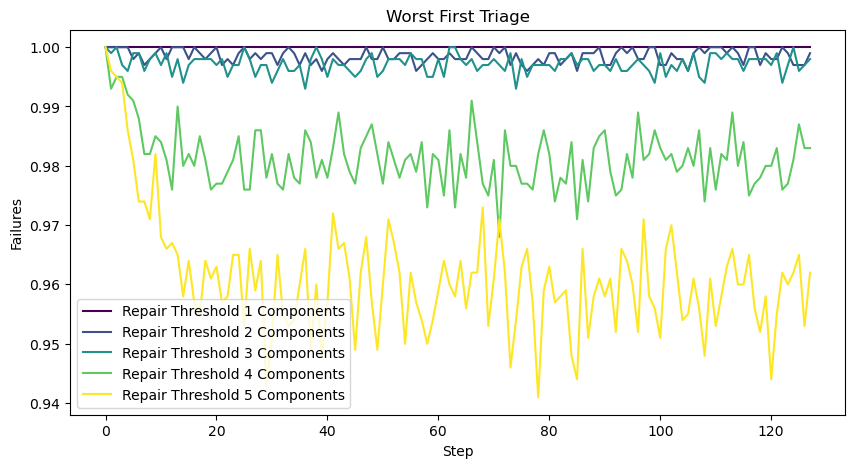

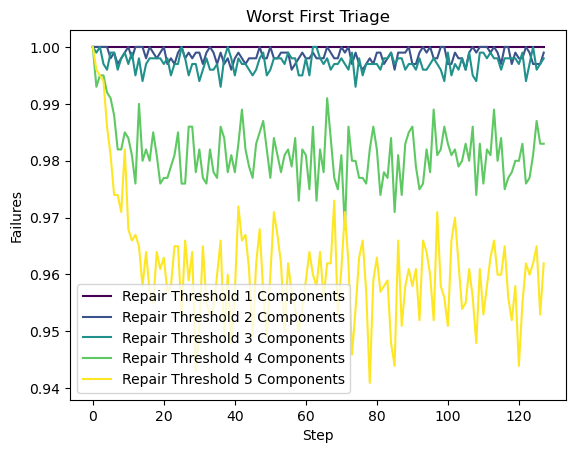

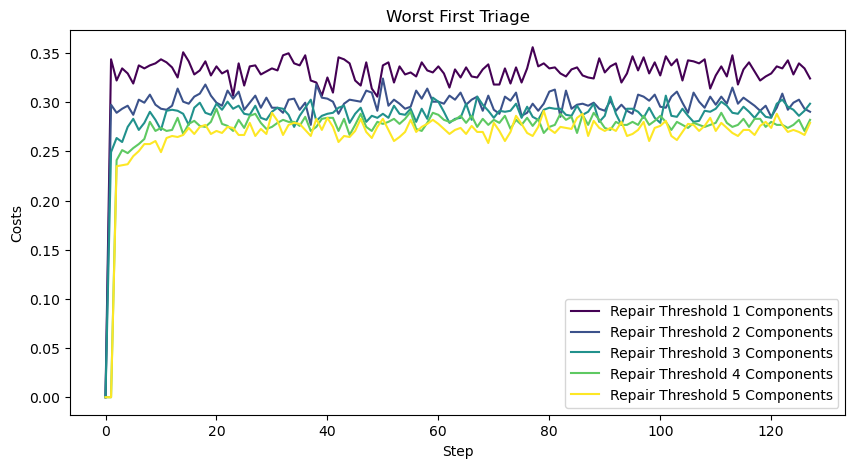

In [14]:
colors = plt.cm.viridis(np.linspace(0, 1, len(cache_cache)))
plt.figure(figsize=(10, 5))
for i, cache_failures in enumerate(cache_cache):
	plt.plot(cache_failures[0], label=f"Repair Threshold {i+1} Components", color=colors[i])
plt.title("Worst First Triage")
plt.xlabel("Step")
plt.ylabel("Failures")
plt.legend()
plt.show()
for i, cache_failures in enumerate(cache_cache):
	plt.plot(cache_failures[0], label=f"Repair Threshold {i+1} Components", color=colors[i])
plt.title("Worst First Triage")
plt.xlabel("Step")
plt.ylabel("Failures")
# plt.ylim(-.01, 0.1)
plt.legend()
plt.show()

# Plot the costs
plt.figure(figsize=(10, 5))
for i, cache_costs in enumerate(cache_cache):
	plt.plot(cache_costs[1], label=f"Repair Threshold {i+1} Components", color=colors[i])
plt.title("Worst First Triage")
plt.xlabel("Step")
plt.ylabel("Costs")
plt.legend()
plt.show()

In [15]:
test_blends = torch.linspace(0.2, 0.98, 25, device=device)

cost_cache = []
utility_cache = []

for blend in tqdm(test_blends, desc="Training Various Blends...", unit="blend"):
	hyperparameters["REWARD_BLEND"] = blend

	dqt_DQAK = MaitenanceDQBNTrainer(hyperparameters, env,)
	dqt_DQAK.create_AK_models()
	dqt_DQAK.train(verbose=False)

	cost, util = dqt_DQAK.benchmark_UC( )

	cost_cache.append(cost)
	utility_cache.append(util)

# plt.scatter( cost_cache, utility_cache )

Training Various Blends...: 100%|██████████| 25/25 [38:33<00:00, 92.55s/blend]


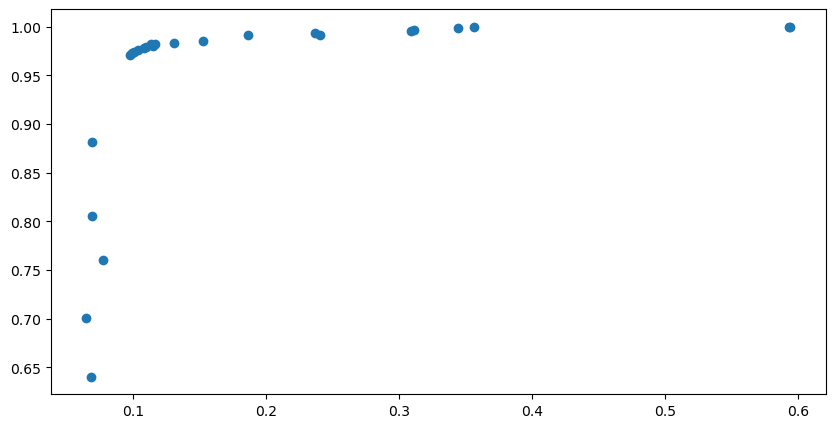

In [16]:
cost_cache = [ x.cpu().numpy() for x in cost_cache ]
utility_cache = [ x.cpu().numpy() for x in utility_cache ]

plt.figure(figsize=(10, 5))
plt.scatter(cost_cache, utility_cache)

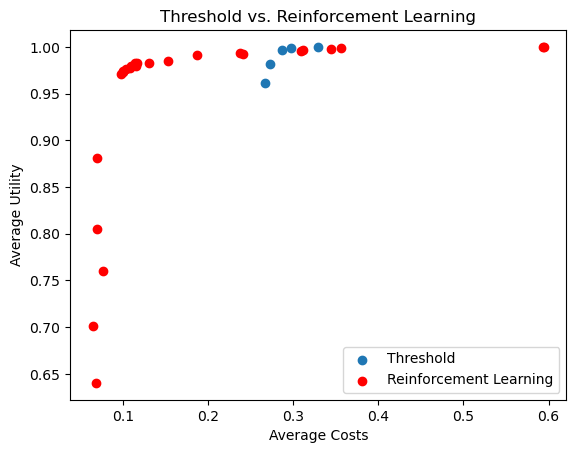

In [17]:
tensor = torch.Tensor([ [np.mean(cache[1]), np.mean(cache[0])] for cache in cache_cache ])
plt.scatter(tensor.T[0], tensor.T[1], label="Threshold")

plt.scatter(cost_cache, utility_cache, color="red", label="Reinforcement Learning")

plt.title("Threshold vs. Reinforcement Learning")
plt.xlabel("Average Costs")
plt.ylabel("Average Utility")
plt.legend()

In [18]:
assert False

AssertionError: 

entropy: 0.08: 100%|██████████| 16384/16384 [01:48<00:00, 150.62it/s]


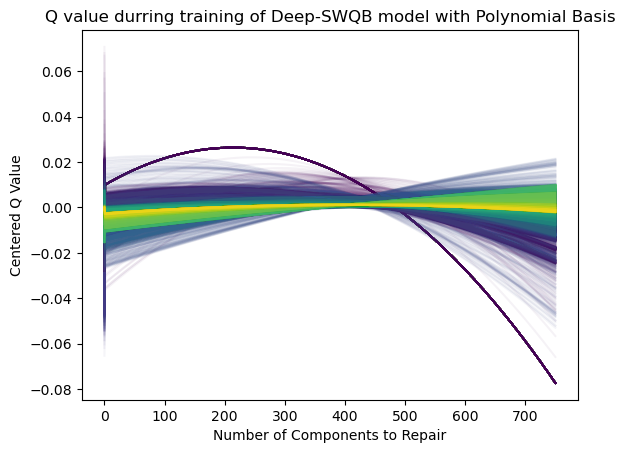

In [ ]:
# Deep SWQB
# hyperparameters["LR"] = DQAK_best_lr
# hyperparameters["DEGREE_APPROXIMATION"] = DQAK_best_degree
# hyperparameters["N_DEEP_NODES"] = DQAK_best_deep
# hyperparameters["BASIS_DOMAIN"] = get_basis(DQAK_best_degree, MAX_REPAIR_CONSTRAINT, basis_type="polynomial")
hyperparameters["REWARD_BLEND"] = 0.7


dqt_DQAK = MaitenanceDQBNTrainer(hyperparameters, env,)
dqt_DQAK.create_AK_models()
q_cache_DQAK = dqt_DQAK.train(test_observation=test_observation)

colors = plt.cm.viridis(np.linspace(0, 1, EPOCHS))

for i, q in enumerate(q_cache_DQAK):
	if True:
		plt.plot(q - q.mean(), alpha = 0.05, color = colors[i])
plt.xlabel("Number of Components to Repair")
plt.ylabel("Centered Q Value")
plt.title("Q value durring training of Deep-SWQB model with Polynomial Basis")
plt.show()

In [ ]:
benchmark_failures = []
benchmark_costs = []

td = env.reset(params_td)
for i in range(EPISODE_LENGTH):
	# take action
	actions, n_repair = dqt_DQAK.select_action(td)
	td["action"] = actions
	# step the enviroment
	td = env.step(td)
	# cache the failures
	td = td["next"]
	benchmark_failures.append(td["utility"][0].item())
	benchmark_costs.append(td["orm_costs"][0].item())
	



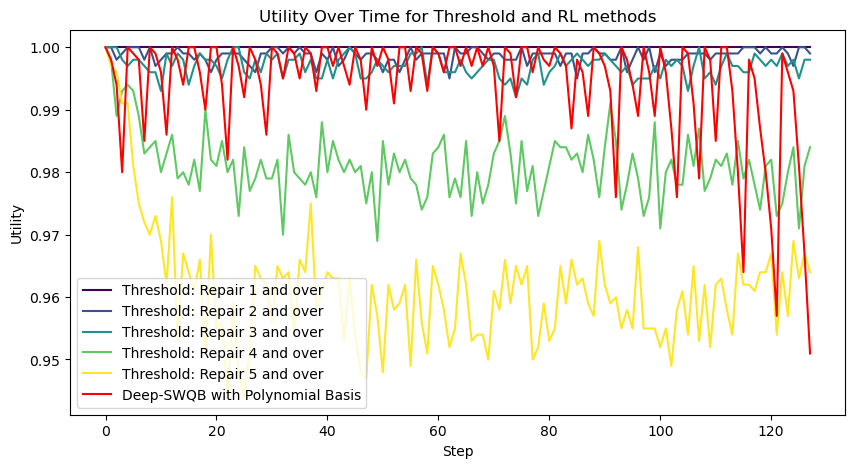

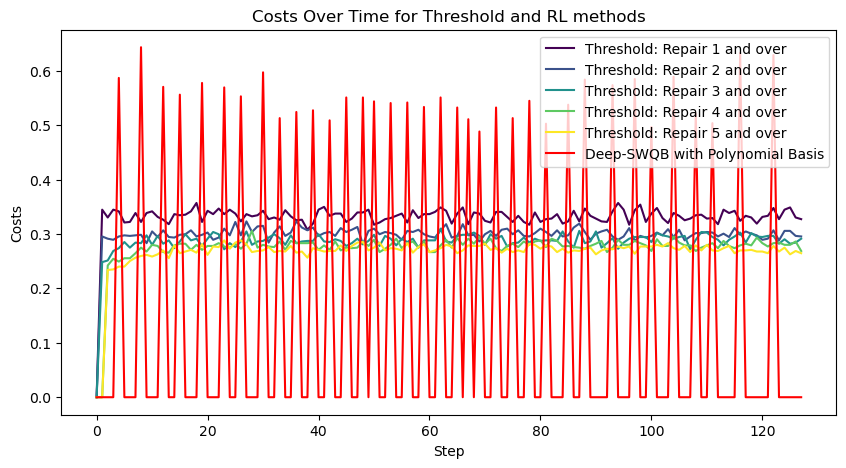

In [ ]:
colors = plt.cm.viridis(np.linspace(0, 1, len(cache_cache)))
plt.figure(figsize=(10, 5))
for i, cache_failures in enumerate(cache_cache):
	plt.plot(cache_failures[0], label=f"Threshold: Repair {i+1} and over", color=colors[i])

plt.plot(benchmark_failures, label="Deep-SWQB with Polynomial Basis", color="red")

plt.title("Utility Over Time for Threshold and RL methods")
plt.xlabel("Step")
plt.ylabel("Utility")
plt.legend()
plt.show()


# Plot the costs
plt.figure(figsize=(10, 5))
for i, cache_costs in enumerate(cache_cache):
	plt.plot(cache_costs[1], label=f"Threshold: Repair {i+1} and over", color=colors[i])

plt.plot(benchmark_costs, label="Deep-SWQB with Polynomial Basis", color="red")

plt.title("Costs Over Time for Threshold and RL methods")
plt.xlabel("Step")
plt.ylabel("Costs")
plt.legend()
plt.show()

In [ ]:
benchmark_costs

[0.0,
 0.0,
 0.0,
 0.0,
 0.5866667032241821,
 0.0,
 0.0,
 0.0,
 0.6430769562721252,
 0.0,
 0.0,
 0.0,
 0.5702564716339111,
 0.0,
 0.0,
 0.5558974742889404,
 0.0,
 0.0,
 0.0,
 0.5774359107017517,
 0.0,
 0.0,
 0.0,
 0.5692307949066162,
 0.0,
 0.0,
 0.5528205037117004,
 0.0,
 0.0,
 0.0,
 0.5969231128692627,
 0.0,
 0.0,
 0.5128205418586731,
 0.0,
 0.0,
 0.5241025686264038,
 0.0,
 0.0,
 0.5271795392036438,
 0.0,
 0.0,
 0.508717954158783,
 0.0,
 0.0,
 0.5507692694664001,
 0.0,
 0.0,
 0.5507692694664001,
 0.0,
 0.5435897707939148,
 0.0,
 0.0,
 0.5405128002166748,
 0.0,
 0.0,
 0.5415384769439697,
 0.0,
 0.0,
 0.5333333611488342,
 0.0,
 0.0,
 0.5507692694664001,
 0.0,
 0.0,
 0.5323077440261841,
 0.0,
 0.510769248008728,
 0.0,
 0.4882051348686218,
 0.0,
 0.0,
 0.5323077440261841,
 0.0,
 0.0,
 0.5128205418586731,
 0.0,
 0.0,
 0.5446153879165649,
 0.0,
 0.0,
 0.5025640726089478,
 0.0,
 0.0,
 0.0,
 0.5374359488487244,
 0.0,
 0.0,
 0.5835897326469421,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5733333230018616,
 0.

In [ ]:
# print mean costs and failures
print("Mean Costs and Failures")
print("RL:\t\t\t\t ", np.mean(benchmark_costs), "\t\t" ,np.mean(benchmark_failures))
# print mean costs and failures for each repair threshold
for i, cache in enumerate(cache_cache):
	print(f"Repair Threshold {i+1} Components: ", np.mean(cache[1]),"\t\t" ,np.mean(cache[0]))


Mean Costs and Failures
RL:				  0.15476763457991183 		 0.9941582242026925
Repair Threshold 1 Components:  0.33054488501511514 		 1.0
Repair Threshold 2 Components:  0.29850962990894914 		 0.9986783666536212
Repair Threshold 3 Components:  0.2861778981750831 		 0.9970517409965396
Repair Threshold 4 Components:  0.2740544988773763 		 0.9810982970520854
Repair Threshold 5 Components:  0.2665785363642499 		 0.9612503331154585


Text(0, 0.5, 'Expected Utility')

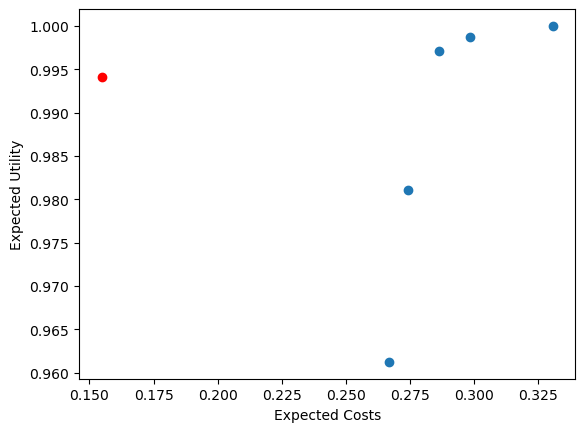

In [ ]:
tensor = torch.Tensor([ [np.mean(cache[1]), np.mean(cache[0])] for cache in cache_cache ])
plt.scatter(tensor.T[0], tensor.T[1], label="Costs")
# plot point
plt.scatter([np.mean(benchmark_costs)], [np.mean(benchmark_failures)], color="red", label="DQAK")
plt.xlabel("Expected Costs")
plt.ylabel("Expected Utility")

(0.9841582242026925, 1.0041582242026925)

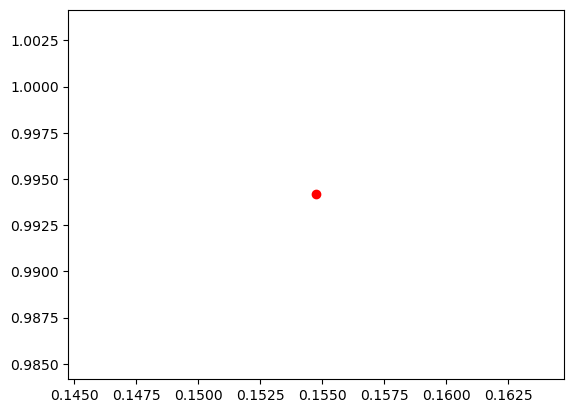

In [ ]:
tensor = torch.Tensor([ [np.mean(cache[1]), np.mean(cache[0])] for cache in cache_cache ])
plt.plot(tensor.T[0], tensor.T[1], label="Costs")
# plot point
point = [np.mean(benchmark_costs), np.mean(benchmark_failures)]
plt.scatter(point[0], point[1], color="red", label="DQAK")

# zoom around point
plt.xlim(point[0] - 0.01, point[0] + 0.01)
plt.ylim(point[1] - 0.01, point[1] + 0.01)